# Tutorial on MetaSynth-disclosure

In this tutorial, we will show how to use the MetaSynth disclosure control plugin. It uses the same procedure as the base MetaSynth [package](https://github.com/sodascience/metasynth/blob/main/examples/advanced_tutorial.ipynb). The output format will be the same: a GMF file will be created with the same parameter types as with the base package. One difference is that not all distributions are implemented by the disclosure plugin. The missing distributions will not be fit by default, but they can be manually set.

In [1]:
# import required packages
from collections import defaultdict
import datetime as dt

import numpy as np
import polars as pl
from matplotlib import pyplot as plt

from metasynth import MetaFrame
from metasynthcontrib.disclosure import DisclosurePrivacy
from metasynth.provider import DistributionProviderList
from utils import get_demonstration_fp

## Transforming your data into a polars DataFrame

The first step in creating the metadata is reading and converting your dataset to a polars DataFrame. 

In [2]:
demonstration_fp = get_demonstration_fp()
df = pl.read_csv(
    source=demonstration_fp, 
    try_parse_dates=True,
    dtypes={
        "Sex": pl.Categorical,
        "Embarked": pl.Categorical
    }
)
df.head()

PassengerId,Name,Sex,Age,Parch,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,f64,str,cat,date,time,datetime[μs],str
1,"""Braund, Mr. Ow…","""male""",22,0,7.25,null,"""S""",1937-10-28,15:53:04,2022-08-05 04:43:34,null
2,"""Cumings, Mrs. …","""female""",38,0,71.2833,"""C85""","""C""",null,12:26:00,2022-08-07 01:56:33,null
3,"""Heikkinen, Mis…","""female""",26,0,7.925,null,"""S""",1931-09-24,16:08:25,2022-08-04 20:27:37,null
4,"""Futrelle, Mrs.…","""female""",35,0,53.1,"""C123""","""S""",1936-11-30,null,2022-08-07 07:05:55,null
5,"""Allen, Mr. Wil…","""male""",35,0,8.05,null,"""S""",1918-11-07,10:59:08,2022-08-02 15:13:34,null


### A full example with the base package

Below we have the synthesis that uses the base MetaSynth package so that we can see potential problems with it. For a more detailed explanation of the base package, see our base [tutorial](https://github.com/sodascience/metasynth/blob/main/examples/advanced_tutorial.ipynb).

In [11]:
from metasynth.distribution import RegexDistribution, FakerDistribution
from metasynth.distribution import DiscreteUniformDistribution

cabin_distribution = RegexDistribution(r"[ABCDEF]\d{2,3}")
var_spec = {
    "PassengerId": {"unique": True}, 
    "Name":        {"distribution": FakerDistribution("name")},
    "Fare":        {"distribution": "exponential"}, # Fit an exponential distribution based on the data
    "Age":         {"distribution": DiscreteUniformDistribution(20, 40)},
    "Cabin":       {"distribution": cabin_distribution}
}

meta_frame = MetaFrame.fit_dataframe(df, spec=var_spec)
print(f"Lower bound distribution:  {meta_frame['Married since'].distribution.start}\n"
      f"Lowest value in dataframe: {df['Married since'].min()}")
meta_frame.synthesize(5)

Lower bound distribution:  2022-07-15 12:21:15
Lowest value in dataframe: 2022-07-15 12:21:15


PassengerId,Name,Sex,Age,Parch,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,f64,f32,cat,date,time,datetime[μs],f32
1,"""Luis Vang""","""male""",35,0,18.287625,null,"""S""",1931-12-10,15:39:48,2022-08-02 01:01:39,null
2,"""Lance Leonard""","""male""",39,0,52.205543,null,"""S""",1916-01-04,15:30:18,2022-08-03 00:04:54,null
3,"""Angela Mullins…","""male""",22,0,5.532566,null,"""C""",1906-04-11,15:58:14,2022-07-28 14:11:53,null
4,"""John Rodriguez…","""female""",null,1,47.797455,null,"""S""",1916-05-14,13:16:04,2022-08-06 00:41:57,null
5,"""Charles Wallac…","""male""",21,0,23.83869,null,"""S""",1920-12-01,15:15:29,2022-07-27 03:17:34,null


From the previous results, we can see the problem that can sometimes happen with the base package: the earliest datetime of the "Married since" column gets recorded in the distribution itself, and thus in the resulting GMF file.

### A full example with disclosure

Below is the same example with the MetaSynth disclosure plugin.

In [12]:
meta_frame = MetaFrame.fit_dataframe(
    df=df, 
    spec=var_spec,
    dist_providers="metasynth-disclosure",  # Use the metasynth-disclosure plugin
    privacy=DisclosurePrivacy()             # Use disclosure control
) 
print(f"Lower bound distribution:  {meta_frame['Married since'].distribution.start}\n"
      f"Lowest value in dataframe: {df['Married since'].min()}")
meta_frame.synthesize(5)

Lower bound distribution:  2022-07-15 17:12:24
Lowest value in dataframe: 2022-07-15 12:21:15


PassengerId,Name,Sex,Age,Parch,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,f64,f32,cat,date,time,datetime[μs],f32
0,"""Luis Vang""","""male""",24,1,73.802375,null,"""C""",1912-05-30,null,2022-08-07 00:42:26,null
1,"""Lance Leonard""","""male""",20,0,5.04999,null,"""S""",1938-07-11,17:11:19,2022-08-12 11:29:54,null
2,"""Angela Mullins…","""male""",35,0,29.116353,null,"""S""",1931-08-09,13:12:52,2022-07-17 01:30:51,null
3,"""John Rodriguez…","""female""",30,0,10.695394,null,"""C""",1905-03-14,10:52:18,2022-08-01 22:05:39,null
4,"""Charles Wallac…","""male""",34,1,2.608667,null,"""S""",1910-12-20,18:17:05,2022-07-25 15:26:11,null


As you can see, the disclosure plugin fixes the privacy concern present in the base MetaSynth package: the lower bound of the distribution is no longer equal to the lowest value in the dataframe.

## Single outliers

Below we will look at what happens to our parameters if we add a single new value (outlier) to the data. We do this for both the base MetaSynth implementation and the disclosure control implementation. We expect that following the rules of disclosure control, a single outlier should have a smaller (and limited) effect on the results than with the base MetaSynth implementation.

Define the plotting function.

In [9]:
def plot_outliers(dist_type, series_size=100):
    dist_providers = DistributionProviderList(["builtin", "metasynth-disclosure"])
    disc_distributions = dist_providers._get_dist_list(var_type=dist_type, privacy=DisclosurePrivacy())
    
    for disc_class in disc_distributions:
        base_class = dist_providers.find_distribution(disc_class.implements)

        dist = base_class.default_distribution()
        series = pl.Series([dist.draw() for _ in range(series_size)])
        clean_base_param = base_class.fit(series).to_dict()["parameters"]
        clean_disc_param = disc_class.fit(series).to_dict()["parameters"]

        base_param = defaultdict(lambda: [])
        disc_param = defaultdict(lambda: [])
        def _add(parameters, param, new_val):
            for key, val in param.items():
                parameters[key].append(val)
            parameters["new_val"].append(new_val)

        for new_val in np.linspace(-100, 100, 101):
            new_series = series.extend_constant(new_val, 1)
            base_dist = base_class.fit(new_series)
            disc_dist = disc_class.fit(new_series)
            _add(base_param, base_dist.to_dict()["parameters"], new_val)
            _add(disc_param, disc_dist.to_dict()["parameters"], new_val)

        for param in base_param:
            if param == "new_val":
                continue
            plt.plot(base_param["new_val"], np.array(base_param[param])-clean_base_param[param], label="base")
            plt.plot(disc_param["new_val"], np.array(disc_param[param]) - clean_disc_param[param], label="disclosure")
            plt.title(f"{disc_class.__name__}: {param}")
            plt.ylabel("Difference between dist with and without outlier")
            plt.xlabel("Value of the outlier")
            plt.legend()
            plt.show()


### Graphs for all continuous distributions

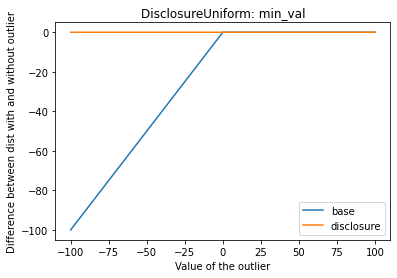

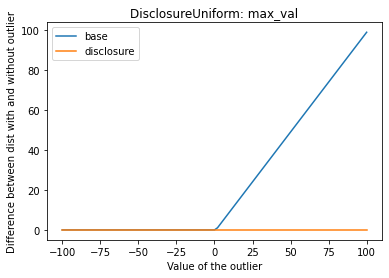

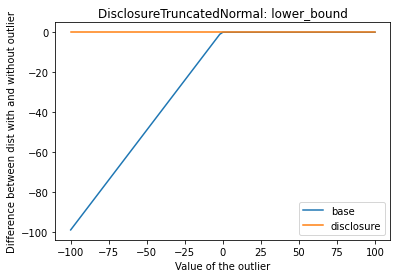

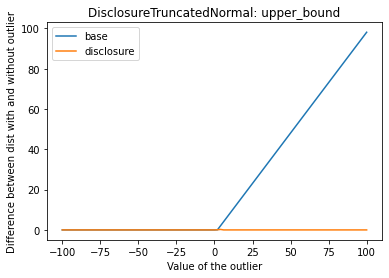

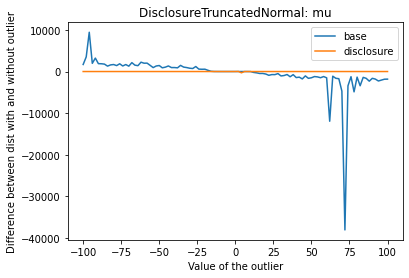

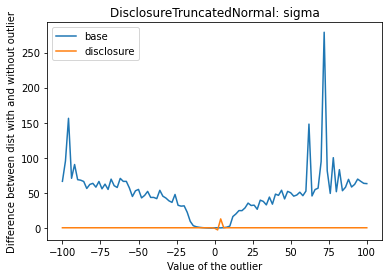

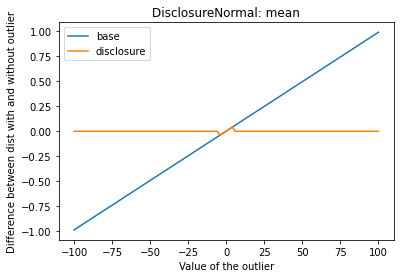

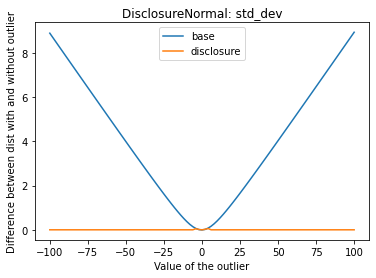

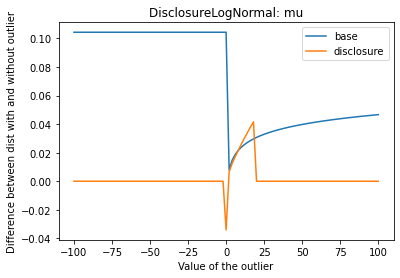

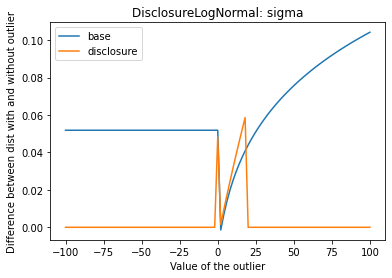

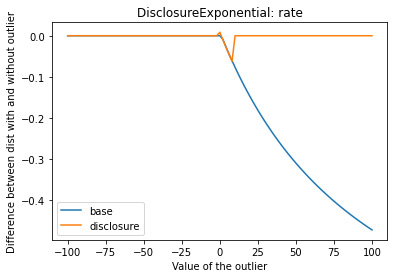

In [10]:
plot_outliers("continuous")

As we can see, the effect from outliers is much reduced compared to the baseline implementation. For all of the distributions, the change in the result is much smaller when an outlier is added.

### Graphs for all discrete distributions

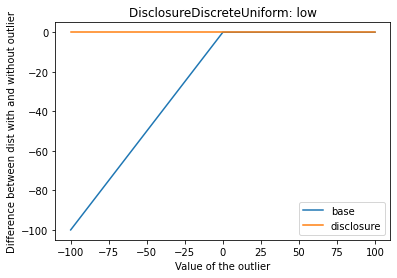

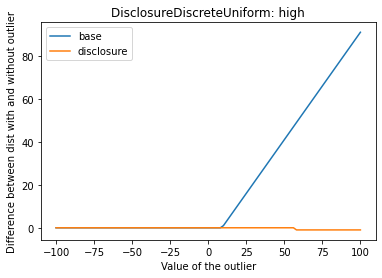

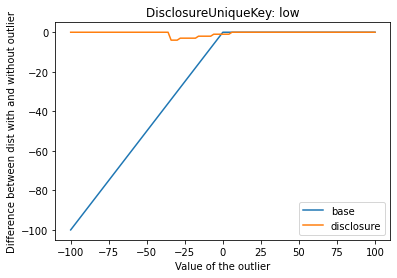

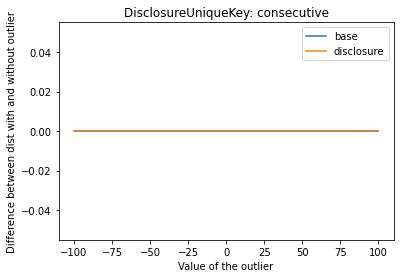

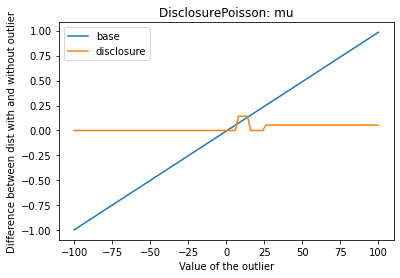

In [11]:
plot_outliers("discrete")

The same is true for the discrete distributions, only a localized effect is present.